IN THIS FILE, I AM GOING TO DO SOME DATA MINING FROM A FEW APIs.

In [69]:
#libraries I use here
import requests
from io import StringIO #TO UNWRAP THE DATA, AS IT COMES AS A STRING IF datatype: 'csv' 
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns

ETH data from API

In [ ]:
#Getting the list of available coins from CoinGecko

url = "https://api.coingecko.com/api/v3/coins/list"

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": os.getenv("COINGECKO_API_KEY")
}

response = requests.get(url, headers=headers)


In [54]:
data = response.json()
df = pd.DataFrame(data)
df.head()

,id,symbol,name
0,_,gib,༼ つ ◕_◕ ༽つ
1,01coin,zoc,01coin
2,0chain,zcn,Zus
3,0dog,0dog,Bitcoin Dogs
4,0-knowledge-network,0kn,0 Knowledge Network


In [55]:
#Searching for a specific coin
df[df['name'] == 'Ethereum']

,id,symbol,name
5335,ethereum,eth,Ethereum


In [ ]:

def fetch_eth_market_data(api_key_gecko, days=90, vs_currency='usd'):
    
    """
    Fetch Ethereum market data from CoinGecko API and return as a merged DataFrame.

    Parameters:
    - days (int): Number of days of historical data to retrieve.
    - vs_currency (str): Currency to compare against (default is 'usd').
    - api_key (str): CoinGecko API key.

    Returns:
    - DataFrame with columns: timestamp, price, market_cap, volume.
    """

    url = f"https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": api_key_gecko
    }
    params = {
        "vs_currency": vs_currency,
        "days": days
    }

    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()  # raise exception if request failed

    data = response.json()

    # Convert and clean data
    df_prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    df_market_caps = pd.DataFrame(data['market_caps'], columns=['timestamp', 'market_cap'])
    df_volumes = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'volume'])

    # Convert timestamps from ms to datetime
    for df in [df_prices, df_market_caps, df_volumes]:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Merge all dataframes on timestamp
    df = df_prices.merge(df_market_caps, on='timestamp').merge(df_volumes, on='timestamp')

    return df

# Example usage:
df_eth = fetch_eth_market_data(api_key_gecko=os.getenv("COINGECKO_API_KEY"))


In [59]:
df_eth

,timestamp,price,market_cap,volume
0,2024-12-27 19:03:59.861,3356.763649,4.044372e+11,2.515555e+10
1,2024-12-27 20:03:44.873,3353.218863,4.039438e+11,2.566027e+10
2,2024-12-27 21:04:10.808,3339.473932,4.018590e+11,2.500714e+10
3,2024-12-27 22:03:44.742,3315.569371,3.995957e+11,2.474787e+10
4,2024-12-27 23:03:59.615,3317.367394,3.996232e+11,2.488310e+10
...,...,...,...,...
2153,2025-03-27 15:02:44.042,2024.403388,2.438641e+11,1.270501e+10
2154,2025-03-27 16:02:50.300,2005.782325,2.421366e+11,1.273288e+10
2155,2025-03-27 17:03:48.812,2001.003790,2.414286e+11,1.339438e+10
2156,2025-03-27 18:04:28.540,1999.836543,2.412641e+11,1.308714e+10


In [65]:
#check if there is no NULL values
df_eth.isnull().sum()

timestamp     0
price         0
market_cap    0
volume        0
dtype: int64

A quick check of the data with a plot

Text(0.5, 1.0, 'ETH PRICE OVER TIME')

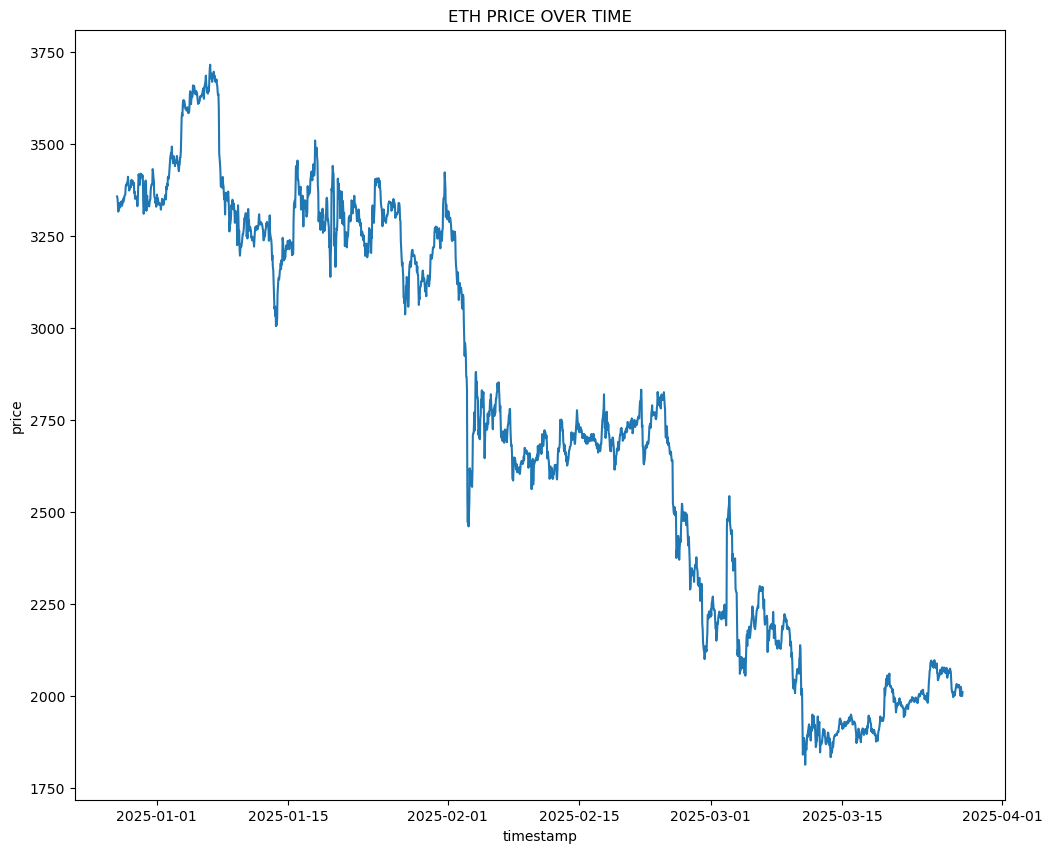

In [63]:
plt.figure(figsize=(12,10))
sns.lineplot(data=df_eth, x='timestamp', y='price')
plt.title('ETH PRICE OVER TIME')

In [ ]:
'''
From my point of view, the resulting data frame, 
can not be used in this project and I have a 
couple of reasons to think about it like this:
  1) It is too short;
  2) The scale (1 hour) is appropriate, 
     but only if we have a lot more lines in our data. 


At first, I thought, maybe I could use another API provider to gather the data
(I tried CoinMarketCap, CoinGecko, WorldCoinIndex, and Alpha Vantage for Crypto Currencies), 
but after doing some research I figured there are no free services that provide GOOD INTRADAY data, 
especially if we want it to be HISTORICAL enough (at least 25000 lines).
'''

So let's move to plan B, and check if we can get enough API data in stocks like AAPL (Apple Inc.).

---------------------------------------

In [ ]:
"""
    Fetch Apple (AAPL) daily prices data from Alpha Vantage and save to CSV.

    Parameters:
    - api_key (str): Your Alpha Vantage API key.
    - output_file (str): Path to save the CSV file (default is 'DATA/aapl_alpha_daily.csv').

    Returns:
    - DataFrame with TimeStamp, Open, High, Low, Close, Volume.
"""


def fetch_data_AV(api_key, output_file='DATA/aapl_alpha_daily.csv'):
    
    url = 'https://www.alphavantage.co/query'
    params = {
        'function': 'TIME_SERIES_DAILY',
        'symbol': 'AAPL',
        'outputsize': 'full',
        'datatype': 'csv',
        'apikey': api_key
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Error {response.status_code}: {response.text}")
        return

    # Convert response text to DataFrame
    df_aapl = pd.read_csv(StringIO(response.text))
    
    # Convert TimeStamp to pandas class for dates 
    df_aapl['timestamp'] = pd.to_datetime(df_aapl['timestamp'], format="%Y-%m-%d")

    # Ensure the directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)


    # Save DataFrame to CSV
    df_aapl.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")

    return df_aapl

# Example usage
fetch_data_AV(api_key=os.getenv('ALPHA_VANTAGE_API'))


Data saved to DATA/aapl_alpha_daily.csv


,timestamp,open,high,low,close,volume
0,2025-03-26,223.51,225.0200,220.47,221.53,34532656
1,2025-03-25,220.77,224.1000,220.08,223.75,34493583
2,2025-03-24,221.00,221.4800,218.58,220.73,44299483
3,2025-03-21,211.56,218.8400,211.28,218.27,94127768
4,2025-03-20,213.99,217.4899,212.22,214.10,48862947
...,...,...,...,...,...,...
6384,1999-11-05,84.62,88.3700,84.00,88.31,3721500
6385,1999-11-04,82.06,85.3700,80.62,83.62,3384700
6386,1999-11-03,81.62,83.2500,81.00,81.50,2932700
6387,1999-11-02,78.00,81.6900,77.31,80.25,3564600


In [ ]:
'''
 When reading the data from DATA it is important to use parse_dates = ['timestamp']
 Otherwise, there will be a problem with types: time will be 'str' agian. 
'''

"\n When reading the data from DATA it is important to use parse_dates = ['timestamp']\n Otherwise, there will be a problem with types: \n"

In [67]:
df_aapl=pd.read_csv('DATA/aapl_alpha_daily.csv', parse_dates = ['timestamp'])

In [68]:
type(df_aapl['timestamp'].iloc[0]) #the timestamp has correct type now)

pandas._libs.tslibs.timestamps.Timestamp

Let's take a little peek at the data.

<Axes: xlabel='timestamp', ylabel='open'>

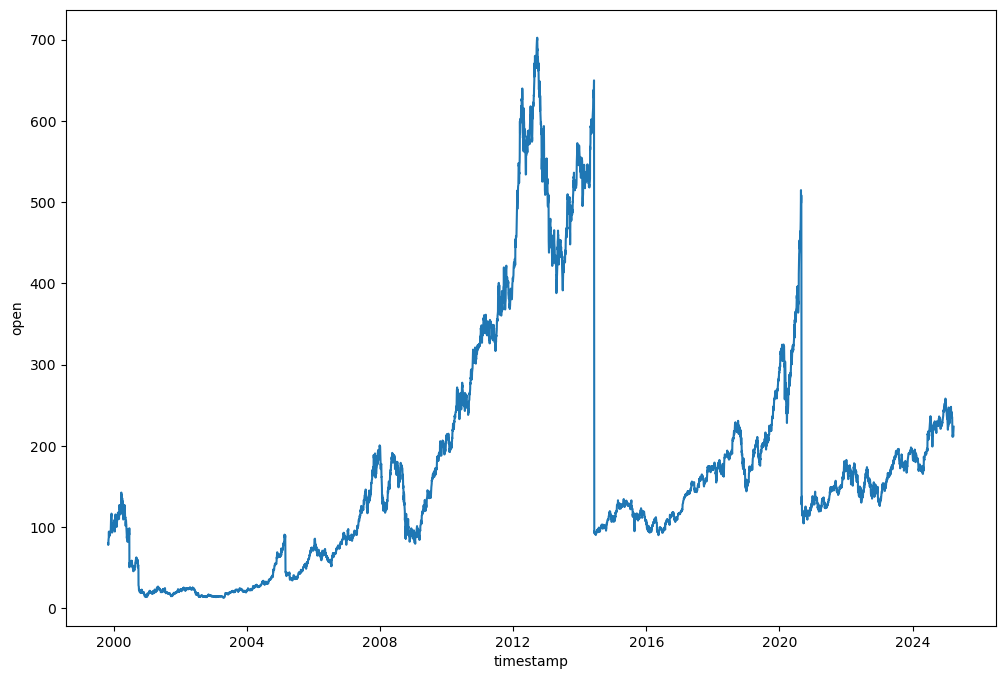

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(df_aapl, x='timestamp', y='open')

In [ ]:
'''
The data seems incorrect. 
How? idk)
'''

'\nThe data seems incorrect. \nHow? idk)\n'

In [ ]:
'''
After doing the same research but for the Stock market, 
I am finally ready to simply find a ready-to-use dataset 
and stick to it, especially, if that is going to be
crypto data, as I planned initially. 
'''

Let's find a good data, finally)!

I used Kaggle to find the ETH dataset we will use in this project.